In [81]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, merge, Input, Lambda
from keras.layers import Convolution2D, Convolution3D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from support.dcmx import DICOMReader
from sklearn.preprocessing import minmax_scale
from scipy.misc import imresize
from os import listdir, walk
from os.path import join, isfile
from support.enorm import EnergyNormalization
gray()
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Some params

In [32]:
# Artems U-net params
DO_LRN = False
X_IMAGE_SIZE = 320
LUNG_MODEL = '../Models/lung_segmentation_tb_lrn_u-net_04Nov2016_150.h5'

# JSRT PARAMS
JSRT_DIMS = 2048
JSRT_PATH = '../../data/All247images/'
TB2_PATH = '../../data/2TB/'
TB2_MASKS = '../../data/2TB/masks'

TEST_PATH = '../../data/TbDispensary/'
MASKS_PATH = '../../data/All247images/masks/masks'

Artem's U-Net implementation

In [4]:
def get_u_net(DO_LRN=False, X_IMAGE_SIZE=320):
    main_input = Input(shape=(1, X_IMAGE_SIZE, X_IMAGE_SIZE))
    input_shape = (-1, 1, X_IMAGE_SIZE, X_IMAGE_SIZE)

    convolution_1_1 = Convolution2D(8, 3, 3, \
                                    input_shape=input_shape, activation='relu', border_mode='same')(main_input)
    convolution_1_2 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(convolution_1_1)
    pool_1 = MaxPooling2D(pool_size=(2, 2))(convolution_1_2)

    if DO_LRN:
        normalize_1 = LRN2D()(pool_1)
        convolution_2_1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(normalize_1)
    else:
        convolution_2_1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(pool_1)
    convolution_2_2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(convolution_2_1)
    pool_2 = MaxPooling2D(pool_size=(2, 2))(convolution_2_2)

    if DO_LRN:
        normalize_2 = LRN2D()(pool_2)
        convolution_3_1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(normalize_2)
    else:
        convolution_3_1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool_2)
    convolution_3_2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(convolution_3_1)
    pool_3 = MaxPooling2D(pool_size=(2, 2))(convolution_3_2)

    if DO_LRN:
        normalize_3 = LRN2D()(pool_3)
        convolution_4_1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(normalize_3)
    else:
        convolution_4_1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool_3)
    convolution_4_2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(convolution_4_1)
    pool_4 = MaxPooling2D(pool_size=(2, 2))(convolution_4_2)

    if DO_LRN:
        normalize_4 = LRN2D()(pool_4)
        convolution_5_1 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(normalize_4)
    else:
        convolution_5_1 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool_4)
    convolution_5_2 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(convolution_5_1)

    first_upsampled = UpSampling2D(size=(2, 2))(convolution_5_2)
    first_merged = merge([first_upsampled, convolution_4_2], mode='concat', concat_axis=1)
    if DO_LRN:
        normalize_5 = LRN2D()(first_merged)
        convolution_6_1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(normalize_5)
    else:
        convolution_6_1 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(first_merged)
    convolution_6_2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(convolution_6_1)

    second_upsampled = UpSampling2D(size=(2, 2))(convolution_6_2)
    second_merged = merge([second_upsampled, convolution_3_2], mode='concat', concat_axis=1)
    if DO_LRN:
        normalize_6 = LRN2D()(second_merged)
        convolution_7_1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(normalize_6)
    else:
        convolution_7_1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(second_merged)
    convolution_7_2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(convolution_7_1)

    third_upsampled = UpSampling2D(size=(2, 2))(convolution_7_2)
    third_merged = merge([third_upsampled, convolution_2_2], mode='concat', concat_axis=1)
    if DO_LRN:
        normalize_7 = LRN2D()(third_merged)
        convolution_8_1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(normalize_7)
    else:
        convolution_8_1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(third_merged)
    convolution_8_2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(convolution_8_1)

    fourth_upsampled = UpSampling2D(size=(2, 2))(convolution_8_2)
    fourth_merged = merge([fourth_upsampled, convolution_1_2], mode='concat', concat_axis=1)
    if DO_LRN:
        normalize_8 = LRN2D()(fourth_merged)
        convolution_9_1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(normalize_8)
    else:
        convolution_9_1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(fourth_merged)
    convolution_9_2 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(convolution_9_1)

    convolution_10_1 = Convolution2D(1, 1, 1, activation='sigmoid')(convolution_9_2)
    
    return Model(input=main_input, output=convolution_10_1) 

In [5]:
unet = get_u_net()
unet.compile(optimizer='adam', loss='binary_crossentropy')

Load pretrained model

In [6]:
from keras.models import load_model
unet.load_weights(LUNG_MODEL)

../../data/TbDispensary/
<generator object walk at 0x7f6ffe0860a0>
step: ../../data/TbDispensary/image001.dcm  0
step: ../../data/TbDispensary/image002.dcm  1
step: ../../data/TbDispensary/image003.dcm  2
step: ../../data/TbDispensary/image004.dcm  3
step: ../../data/TbDispensary/image005.dcm  4
step: ../../data/TbDispensary/image006.dcm  5
step: ../../data/TbDispensary/image007.dcm  6
step: ../../data/TbDispensary/image008.dcm  7
step: ../../data/TbDispensary/image001.json  0
step: ../../data/TbDispensary/image002.json  1
step: ../../data/TbDispensary/image003.json  2
step: ../../data/TbDispensary/image004.json  3
step: ../../data/TbDispensary/image005.json  4
step: ../../data/TbDispensary/image006.json  5
Throwed
step: ../../data/TbDispensary/image007.json  6
Throwed
step: ../../data/TbDispensary/image008.json  7


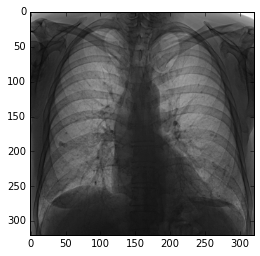

In [70]:
orig = dict()
reader = DICOMReader()
orig['bases'], orig['masks'] = reader.extract_data(0, 8, TEST_PATH)
orig['bases'] = [j for i, j in zip(orig['masks'], orig['bases']) if i.sum()]
orig['masks'] = [i for i in orig['masks'] if i.sum()]

orig['bases'] = [minmax_scale(imresize(i, (X_IMAGE_SIZE, X_IMAGE_SIZE), "bicubic")
                              .reshape(-1) / 1.)
                 .reshape((X_IMAGE_SIZE, X_IMAGE_SIZE)) 
             for i in orig['bases']]

orig['masks'] = [minmax_scale(imresize(i, (X_IMAGE_SIZE, X_IMAGE_SIZE), "bicubic") / 1.) > 0
                 for i in orig['masks']]

imshow(orig['bases'][0])

JSRT case

Step:  0


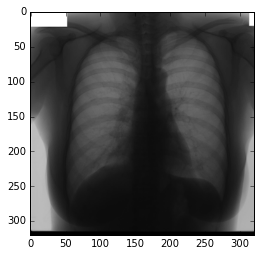

In [60]:
shape = (JSRT_DIMS, JSRT_DIMS) # matrix size
dtype = np.dtype('>u2') # big-endian unsigned integer (16bit)
energy = EnergyNormalization()
images = []
for i, file in enumerate(listdir(JSRT_PATH)[:8]):
    if isfile(join(JSRT_PATH, file)):
        # Reading.
        fid = open(join(JSRT_PATH, file), 'rb')
        data = fromfile(fid, dtype).astype(float)
        data = imresize(data.reshape(shape), (X_IMAGE_SIZE, X_IMAGE_SIZE), "bicubic")
        data = minmax_scale(data.reshape(-1).astype(float)).reshape((X_IMAGE_SIZE, X_IMAGE_SIZE))
        
        images.append([data])
        images.append(energy.iterate_normalization([data], 
                                            [orig['masks'][0]], 
                                            orig['bases'], 
                                            orig['masks'], 
                                            5, 
                                            False))
    if i % 30 == 0:
        print('Step: ', i)
        imshow(data)
images = asarray(images)

2TB Case


../../data/2TB/
<generator object walk at 0x7f6ffe61fc50>
step: ../../data/2TB/334889.dcm  0
step: ../../data/2TB/334890.dcm  1
step: ../../data/2TB/334891.dcm  2
step: ../../data/2TB/334892.dcm  3
step: ../../data/2TB/334893.dcm  4
Step:  0


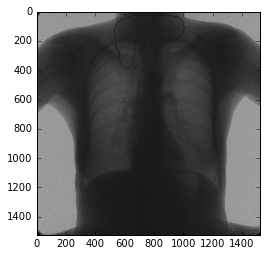

In [72]:
TB = dict()
reader = DICOMReader()
TB['bases'], _ = reader.extract_data(0, 5, TB2_PATH, extract_lungs=False)
energy = EnergyNormalization()
images = []
for i, data in enumerate(TB['bases']):
    data = imresize(data, (X_IMAGE_SIZE, X_IMAGE_SIZE), "bicubic")
    data = minmax_scale(data.reshape(-1).astype(float)).reshape(data.shape)
    images.append(energy.iterate_normalization([data], 
                                        [orig['masks'][0]], 
                                        orig['bases'], 
                                        orig['masks'], 
                                        5, 
                                        False))
    if i % 30 == 0:
        print('Step: ', i)
        imshow(TB['bases'][i])
        show()

images = asarray(TB['bases'])

In [74]:
masks = unet.predict(expand_dims(asarray(orig['bases']), 1))

save(TB2_MASKS, masks)

U-net segmentation results

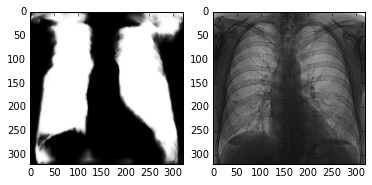

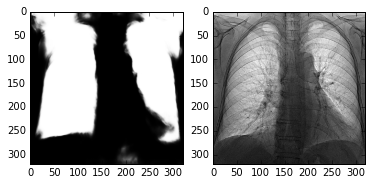

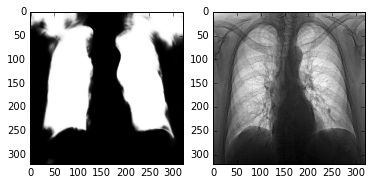

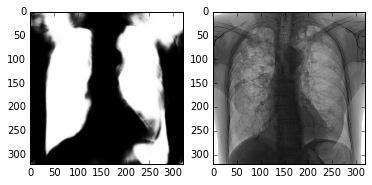

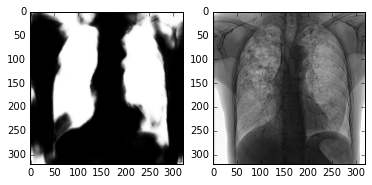

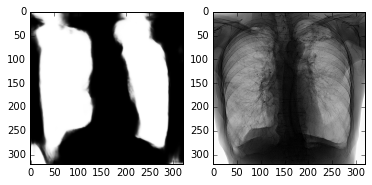

In [76]:
for m, im in zip(masks, expand_dims(asarray(orig['bases']), 1)):
    figure()
    subplot(1, 2, 1)
    imshow(m[0])
    subplot(1, 2, 2)
    imshow(im[0])
    show()

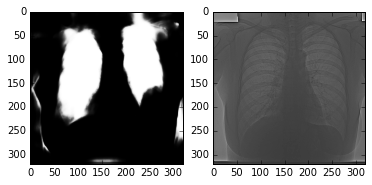

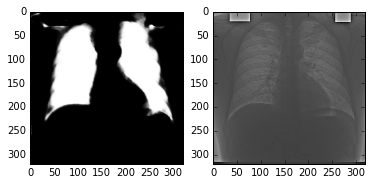

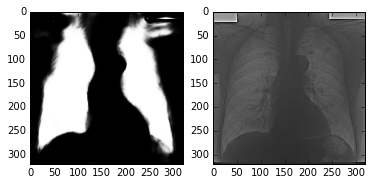

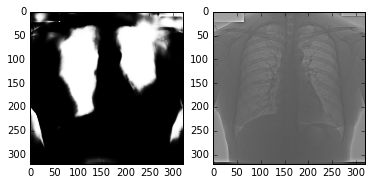

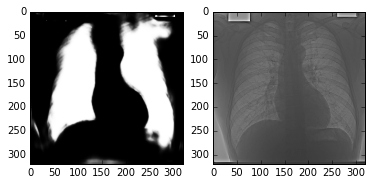

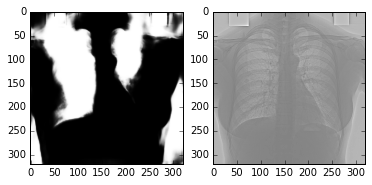

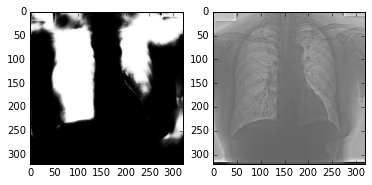

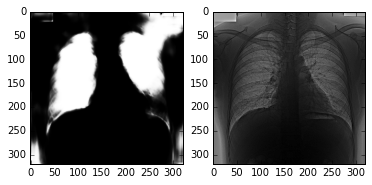

In [53]:
for m, im in zip(masks, images):
    figure()
    subplot(1, 2, 1)
    imshow(m[0])
    subplot(1, 2, 2)
    imshow(im[0])
    show()